
---

# Dask Filters Benchmarking README

## Overview
This repository benchmarks two state estimation filters—`DaskKalmanFilter` and `DaskParticleFilter`—implemented with Dask for scalability. Both filters inherit optimization strategies from a `ParameterEstimator` base class to estimate process noise covariance (\( Q \)) and observation noise covariance (\( R \)). The benchmark evaluates four strategies (`"residual_analysis"`, `"mle"`, `"cross_validation"`, `"adaptive_filtering"`) on a digits dataset for image denoising, measuring execution time and Mean Squared Error (MSE).

- **Purpose**: Compare speed and denoising accuracy across strategies for both filters.
- **Dataset**: Digits dataset (200 samples, 64D images) with synthetic Gaussian noise (\( \sigma = 0.88 \)).
- **Metrics**: Execution time (seconds) and MSE, averaged over 5 runs.

## Optimization Strategies

### 1. Residual Analysis (`"residual_analysis"`)
- **Description**: Estimates \( Q \) and \( R \) by analyzing residuals (prediction errors). For Kalman, residuals are \( z_k - H \hat{x}_{k|k-1} \); for Particle, they’re derived from particle likelihoods. Covariances are updated based on residual variance.
- **Use Case**: Best for stable noise conditions where residuals reflect true noise statistics.
- **Pros**: Fast, data-driven.
- **Cons**: Assumes stationary noise.

### 2. Maximum Likelihood Estimation (`"mle"`)
- **Description**: Optimizes \( Q \) and \( R \) by maximizing the likelihood of observed data. Kalman uses innovation likelihood; Particle approximates over particle distributions (e.g., via Expectation-Maximization).
- **Use Case**: Ideal for precise noise estimation with sufficient data.
- **Pros**: Statistically optimal.
- **Cons**: Computationally intensive.

### 3. Cross-Validation (`"cross_validation"`)
- **Description**: Splits data into train/validation sets, tests multiple \( Q/R \) candidates, and selects the pair minimizing validation MSE.
- **Use Case**: Suitable for limited or noisy data, avoiding overfitting.
- **Pros**: Robust, generalizes well.
- **Cons**: Slow due to multiple filter runs.

### 4. Adaptive Filtering (`"adaptive_filtering"`)
- **Description**: Updates \( Q \) and \( R \) dynamically as data arrives, using rules like residual trends (Kalman) or particle weight variance (Particle).
- **Use Case**: Excels with non-stationary noise (e.g., changing over time).
- **Pros**: Adaptive, real-time capable.
- **Cons**: May overreact to outliers.

## Installation

### Requirements
- Python 3.8+
- Libraries: `numpy`, `dask`, `scikit-learn`, `matplotlib`, `pandas`

2. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```
   Example `requirements.txt`:
   ```
   numpy>=1.21.0
   dask[array]>=2023.0.0
   scikit-learn>=1.0.0
   matplotlib>=3.5.0
   pandas>=1.3.0
   ```

3. Ensure `DaskKalmanFilter` and `DaskParticleFilter` are available 

## Usage

### Example Script
```python
from your_module import DaskKalmanFilter, DaskParticleFilter
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import dask.array as da
import numpy as np
import time

# Load data
digits = load_digits()
x = digits.data[0:200]
x_train, _, _, _ = train_test_split(x, digits.target[0:200], test_size=0.2, random_state=42)
x_train_dask = da.from_array(x_train, chunks=(20, 64))
noisy_x_train_dask = x_train_dask + da.random.normal(0, 0.88, x_train_dask.shape, chunks=x_train_dask.chunks)

# Common parameters
n_features = 64
F = np.eye(n_features) * 0.99
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)

# Benchmark Kalman Filter
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="mle")
start = time.time()
kf.fit(noisy_x_train_dask)
denoised = kf.predict().compute()
print(f"Kalman MLE Time: {time.time() - start:.4f}s")

# Benchmark Particle Filter
pf = DaskParticleFilter(F, H, Q, R, x0, num_particles=1000, use_dask=True, estimation_strategy="mle")
start = time.time()
denoised, _ = pf.run_filter(noisy_x_train_dask)
denoised = denoised.compute()
print(f"Particle MLE Time: {time.time() - start:.4f}s")
```

### Running the Benchmark
Execute the full benchmark script (as provided earlier) to compare all strategies:
```bash
python benchmark_filters.py
```
- Outputs: Console stats and bar plots for execution time and MSE.

## Benchmark Details

### Methodology
- **Data**: 200 digits samples (160 train), 64D each, with Dask chunks `(20, 64)`.
- **Noise**: Gaussian (\( \sigma = 0.88 \)).
- **Runs**: 5 per strategy for statistical reliability.
- **Metrics**:
  - **Execution Time**: Mean and std dev (seconds).
  - **MSE**: Mean and std dev of denoising error vs. original data.
- **Filters**:
  - **Kalman**: Uses `fit()` and `predict()` methods.
  - **Particle**: Uses `run_filter()` with 1000 particles.

### Expected Results
- **Kalman Filter**: Faster due to deterministic updates, moderate MSE variation across strategies.
- **Particle Filter**: Slower due to particle sampling, potentially better MSE with adaptive strategies.
- **Strategy Trends**:
  - `"residual_analysis"`: Fastest, decent MSE.
  - `"mle"`: Slower, potentially lowest MSE.
  - `"cross_validation"`: Slowest, robust MSE.
  - `"adaptive_filtering"`: Moderate speed, excels with dynamic noise.

### Plots
- **Execution Time**: Bar chart with error bars showing mean time and variability.
- **MSE**: Bar chart with error bars showing denoising accuracy.

## Notes
- **Hardware**: Results vary by CPU, memory, and Dask configuration (e.g., local vs. distributed).
- **Scalability**: Increase sample size (e.g., 1000) or chunks for larger tests.
- **Tuning**: Adjust \( Q \), \( R \), or `num_particles` (Particle) for specific use cases.
- **Extensions**: Add memory usage tracking or test on non-stationary noise datasets.

---



In [ ]:
from  tfilterspy.state_estimation.linear_filters import DaskKalmanFilter
from  tfilterspy.state_estimation.particle_filters import DaskParticleFilter

In [3]:
import numpy as np
import dask.array as da
from sklearn.utils.validation import check_array, check_is_fitted

class BaseEstimator:
    """
    Base class for all estimators in the TFilterPy package.
    Provides common functionality such as parameter handling and validation.
    """

    def __init__(self, name=None):
        """
        Initialize the BaseEstimator.

        Args:
            name (str): Optional name for the estimator.
        """
        self.name = name or self.__class__.__name__

    @staticmethod
    def to_dask_array(numpy_array, chunk_size=None):
        """
        Convert a NumPy array to a Dask array with specified chunking.
        If chunk_size is None, use Dask's automatic chunking.
        
        Parameters:
            numpy_array (np.ndarray): Input array.
            chunk_size (int or tuple, optional): Desired chunk size.
            
        Returns:
            da.Array: Dask array version of numpy_array.
        """
        if chunk_size is None:
            return da.from_array(numpy_array, chunks="auto")
        else:
            if isinstance(chunk_size, int):
                chunks = tuple(chunk_size for _ in range(numpy_array.ndim))
            else:
                chunks = chunk_size
            return da.from_array(numpy_array, chunks=chunks)
    
    def get_params(self, deep=True):
        """
        Get parameters of the estimator.

        Args:
            deep (bool): If True, retrieves parameters of nested objects.

        Returns:
            dict: A dictionary of parameter names mapped to their values.
        """
        params = {}
        for key, value in self.__dict__.items():
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                params.update({f"{key}__{k}": v for k, v in deep_items})
            else:
                params[key] = value
        return params

    def set_params(self, **params):
        """
        Set parameters of the estimator.

        Args:
            **params: Arbitrary keyword arguments of parameters to set.

        Returns:
            self: Returns the instance itself.
        """
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f"Invalid parameter: {key}")
            setattr(self, key, value)
        return self

    def validate_matrices(self, matrices):
        """
        Validate that matrices have consistent shapes and types.

        Args:
            matrices (dict): A dictionary of matrix names and their values.

        Raises:
            ValueError: If the matrices are inconsistent.
        """
        for name, matrix in matrices.items():
            if not isinstance(matrix, (np.ndarray, da.Array)):
                raise ValueError(f"{name} must be a NumPy or Dask array.")
            if matrix.ndim != 2:
                raise ValueError(f"{name} must be a 2D array.")
            if matrix.dtype != np.float64:
                raise ValueError(f"{name} must have dtype float64.")
        # Add shape consistency checks here if needed

    def _validate_data(self, X, y=None, reset=True, validate_separately=False, **check_array_params):
        """
        Validate input data using sklearn.utils.validation.check_array.
        """
        if y is None:
            X = check_array(X, reset=reset, validate_separately=validate_separately, **check_array_params)
            return X
        else:
            X, y = check_array(X, y, reset=reset, validate_separately=validate_separately, **check_array_params)
            return X, y

    def _check_is_fitted(self, attributes, msg=None, all_or_any=all):
        """
        Check if the estimator is fitted.
        """
        check_is_fitted(self, attributes, msg=msg, all_or_any=all_or_any)

    def __repr__(self):
        """
        String representation of the estimator.

        Returns:
            str: A string representation of the estimator.
        """
        return f"{self.name}({self.get_params(deep=False)})"

import dask
print(dask.__version__)

import dask.array as da
import numpy as np

class ParameterEstimator(BaseEstimator):
    r"""
    A class for estimating Kalman Filter parameters, such as process noise covariance (Q)
    and observation noise covariance (R), using different estimation methods.

    Estimation strategies include:
    - Residual Analysis
    - Maximum Likelihood Estimation (MLE)
    - Cross-Validation
    - Adaptive Filtering

    References:
    - Welch, G., & Bishop, G. (1995). An Introduction to the Kalman Filter.
    - Haykin, S. (2001). Kalman Filtering and Neural Networks.
    """

    def __init__(self, estimation_strategy: str = "residual_analysis"):
        r"""
        Initialize the ParameterEstimator with the desired estimation strategy.

        Parameters
        ----------
        estimation_strategy : str, optional
            The strategy to use for estimating parameters. Options include:
            - "residual_analysis": Estimate based on residuals after running the filter.
            - "mle": Maximum Likelihood Estimation (iterative approach).
            - "cross_validation": Perform k-fold cross-validation for best Q and R.
            - "adaptive_filtering": Dynamically update Q and R based on measurement residuals.

        Raises
        ------
        ValueError
            If an invalid estimation strategy is specified.
        """
        super().__init__(name="KalmanFilterParameterEstimator")
        valid_strategies = {
            "residual_analysis",
            "mle",
            "cross_validation",
            "adaptive_filtering",
        }
        if estimation_strategy not in valid_strategies:
            raise ValueError(
                f"Invalid strategy: {estimation_strategy}. Must be one of {valid_strategies}."
            )
        self.estimation_strategy = estimation_strategy

    def estimate_with_residual_analysis(self, measurements: da.Array) -> tuple:
        r"""
        Estimate process (Q) and observation (R) noise covariances using residual analysis.
        
        This method runs the Kalman filter on the provided measurements, computes the residuals,
        and estimates the noise covariances based on their statistical properties.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - The process noise covariance (Q) is estimated as the covariance of the residuals.
        - The observation noise covariance (R) is approximated as a diagonal matrix scaled
          by the variance of the residuals.
        - Dask's auto-chunking is used to handle large datasets efficiently.
        """
        state_estimates, residuals = self.run_filter(measurements)
        Q = da.cov(residuals, rowvar=False)
        # Use auto chunking for the identity matrix
        R = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
        return Q, R

    def estimate_with_mle(self, measurements: da.Array, max_iterations: int = 5) -> tuple:
        r"""
        Estimate Q and R using Maximum Likelihood Estimation (MLE) through an iterative approach.
        
        This method iteratively refines the estimates of Q and R by running the Kalman filter
        and updating the covariances based on the residuals until convergence or the maximum
        number of iterations is reached.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        max_iterations : int, optional
            Maximum number of iterations for the MLE process. Default is 5.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - The method uses the variance of residuals to update Q and R in each iteration.
        - Intermediate results are persisted to avoid recomputation overhead in Dask.
        - Convergence is not explicitly checked; the loop runs for a fixed number of iterations.
        """
        Q, R = self.Q, self.R

        for _ in range(max_iterations):
            state_estimates, residuals = self.run_filter(measurements)
            # Use "auto" chunking for the identity matrices
            Q_new = da.eye(residuals.shape[1], chunks="auto") * da.var(residuals, axis=0)
            R_new = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            # Persist intermediate results to avoid recomputation overhead
            Q, R = Q_new.persist(), R_new.persist()

        return Q, R

    def estimate_with_cross_validation(self, measurements: da.Array, k_folds: int = 5) -> tuple:
        r"""
        Estimate Q and R using k-fold cross-validation to find the best noise covariance parameters.
        
        This method splits the data into k folds, trains the Kalman filter on k-1 folds, and
        validates on the remaining fold. The Q and R pair with the lowest validation error is selected.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        k_folds : int, optional
            Number of folds for cross-validation. Default is 5.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix from the best fold.
        R : dask.array.Array
            Estimated observation noise covariance matrix from the best fold.
        
        Notes
        -----
        - The validation score is the mean squared error between predicted and actual measurements.
        - All folds are computed lazily using Dask and finalized with `da.compute`.
        - The method assumes the data can be evenly divided into folds; edge cases may need adjustment.
        """
        n_samples = measurements.shape[0]
        fold_size = n_samples // k_folds

        fold_scores, fold_Qs, fold_Rs = [], [], []

        for fold in range(k_folds):
            val_start = fold * fold_size
            val_end = val_start + fold_size
            train_data = da.concatenate([measurements[:val_start], measurements[val_end:]])
            val_data = measurements[val_start:val_end]

            state_estimates, residuals = self.run_filter(train_data)
            val_score = da.mean((val_data - state_estimates[:fold_size]) ** 2)
            fold_scores.append(val_score)

            Q_fold = da.cov(residuals.T)
            R_fold = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            fold_Qs.append(Q_fold)
            fold_Rs.append(R_fold)

        # Compute all folds lazily and choose the best fold
        fold_scores, fold_Qs, fold_Rs = da.compute(fold_scores, fold_Qs, fold_Rs)
        best_fold = np.argmin(fold_scores)
        return fold_Qs[best_fold], fold_Rs[best_fold]

    def estimate_with_adaptive_filtering(self, measurements: da.Array, alpha: float = 0.01) -> tuple:
        r"""
        Estimate Q and R adaptively based on innovations over time using a smoothing approach.
        
        This method dynamically updates the noise covariances by incorporating new information
        from the innovations (measurement residuals) with a small learning rate.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        alpha : float, optional
            Number of folds for cross-validation. Default is 5.
        
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - Innovations are calculated as the difference between measurements and predicted observations.
        - The update uses an exponential moving average with a fixed alpha (learning rate) of 0.01.
        - Dask's `einsum` is used for efficient outer product computation of innovations.
        """
        Q, R = self.Q, self.R
        # alpha = 0.01
        innovations = measurements - da.dot(self.H, self.x)
        outer_products = da.einsum("ij,ik->ijk", innovations, innovations)
        Q_new = da.mean(outer_products, axis=0).rechunk("auto")
        R_new = da.var(innovations, axis=0).rechunk("auto")

        Q = (1 - alpha) * Q + alpha * Q_new
        R = (1 - alpha) * R + alpha * R_new
        return Q, R

    def estimate_parameters(self, measurements: da.Array):
        r"""
        Estimate the parameters Q and R using the specified estimation strategy.
        
        This method serves as a dispatcher, calling the appropriate estimation method based
        on the initialized `estimation_strategy`.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        
        Returns
        -------
        tuple
            A tuple (Q, R) containing the estimated process and observation noise covariance matrices.
        """
        return getattr(self, f"estimate_with_{self.estimation_strategy}")(measurements)


import numpy as np
import dask.array as da
# from tfilterspy.utils.optimisation_utils import ParameterEstimator



class DaskParticleFilter(ParameterEstimator):
    r"""
    A multivariate, scalable particle filter using Dask. Inherits parameter estimation 
    methods from ParameterEstimator.
    
    This implementation provides a flexible particle filter that can operate with either NumPy 
    or Dask arrays, making it suitable for both small-scale and large-scale state estimation 
    problems. It follows the standard sequential importance resampling (SIR) framework.
    
    References
    ----------
    - Gordon,.ConcurrentN. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
        Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
    - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
        Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
    """
    def __init__(self, state_transition, observation_model, process_noise_cov, 
                 observation_noise_cov, initial_state, num_particles=1000, use_dask=True, 
                 estimation_strategy="residual_analysis"):
        r"""
        Initialize the DaskParticleFilter with filter parameters and estimation strategy.
        
        Parameters
        ----------
        state_transition : array-like
            State transition matrix of shape (state_dim, state_dim) defining the linear 
            dynamics of the system.
        observation_model : array-like
            Observation matrix of shape (obs_dim, state_dim) mapping states to observations.
        process_noise_cov : array-like
            Process noise covariance matrix of shape (state_dim, state_dim).
        observation_noise_cov : array-like
            Observation noise covariance matrix of shape (obs_dim, obs_dim).
        initial_state : array-like
            Initial state vector of shape (state_dim,).
        num_particles : int, optional
            Number of particles to use in the filter. Default is 1000.
        use_dask : bool, optional
            If True, use Dask arrays for scalable computation; otherwise, use NumPy arrays. 
            Default is True.
        estimation_strategy : str, optional
            Strategy for estimating Q and R, inherited from ParameterEstimator. Options include 
            "residual_analysis", "mle", "cross_validation", "adaptive_filtering". Default is 
            "residual_analysis".
        
        Notes
        -----
        - The filter assumes a linear state transition and observation model. For nonlinear 
          models, consider extending with callable functions (see Doucet & Johansen, 2009).
        - When `use_dask` is True, inputs are converted to Dask arrays with chunking for 
          scalability.
        """
        # Initialize the ParameterEstimator
        super().__init__(estimation_strategy=estimation_strategy)
        self.use_dask = use_dask
        self.state_dim = initial_state.shape[0]
        self.num_particles = num_particles

        # Convert inputs to Dask arrays if scalability is desired
        if self.use_dask:
            self.state_transition = da.from_array(state_transition, chunks=state_transition.shape)
            self.observation_model = da.from_array(observation_model, chunks=observation_model.shape)
            self.process_noise_cov = da.from_array(process_noise_cov, chunks=process_noise_cov.shape)
            self.observation_noise_cov = da.from_array(observation_noise_cov, chunks=observation_noise_cov.shape)
            self.initial_state = da.from_array(initial_state, chunks=initial_state.shape)
        else:
            self.state_transition = state_transition
            self.observation_model = observation_model
            self.process_noise_cov = process_noise_cov
            self.observation_noise_cov = observation_noise_cov
            self.initial_state = initial_state

        # Step 1: Initialization - all particles start at the same known state
        particles_np = np.repeat(initial_state.reshape(1, self.state_dim), num_particles, axis=0)
        if self.use_dask:
            self.particles = da.from_array(particles_np, chunks=(num_particles // 10, self.state_dim))
        else:
            self.particles = particles_np
        
        # Uniform weights
        weights_np = np.ones(num_particles) / num_particles
        if self.use_dask:
            self.weights = da.from_array(weights_np, chunks=(num_particles // 10,))
        else:
            self.weights = weights_np

        # Current state estimate (initially set to the initial state)
        self.state = self.initial_state.compute() if self.use_dask else self.initial_state

        # For parameter estimation methods, we store a copy of Q and R (could be updated later)
        # For demonstration, we initialize them as given.
        self.Q = self.process_noise_cov
        self.R = self.observation_noise_cov

    def predict(self):
        r"""
            Propagate each particle forward using the state transition model and Gaussian process noise.
            
            This step implements the prediction phase of the particle filter, where particles are 
            evolved according to the system dynamics plus random noise.
            
            Notes
            -----
            - Noise is sampled from a multivariate normal distribution with covariance `Q`.
            - For Dask, particles are persisted to optimize memory usage in distributed settings.
            - See Gordon et al. (1993) for the foundational SIR algorithm's prediction step.
            
            References
            ----------
            - Gordon, N. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
              Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
        """
        noise_np = np.random.multivariate_normal(
            np.zeros(self.state_dim),
            self.process_noise_cov.compute() if self.use_dask else self.process_noise_cov,
            self.num_particles
        )
        if self.use_dask:
            noise = da.from_array(noise_np, chunks=self.particles.chunksize)
        else:
            noise = noise_np
        
        if self.use_dask:
            self.particles = da.dot(self.particles, self.state_transition.T) + noise
            self.particles = self.particles.persist()
        else:
            self.particles = (self.state_transition @ self.particles.T).T + noise

    def update(self, measurement):
        r"""
            Update particle weights based on the likelihood of the observed measurement.
            
            This step computes the likelihood of each particle given the measurement and updates 
            their weights accordingly, followed by resampling and state estimation.
            
            Parameters
            ----------
            measurement : array-like
                Observed measurement vector of shape (obs_dim,).
            
            Notes
            -----
            - Assumes a scalar observation noise variance (R[0, 0]) for simplicity. For multivariate 
              observations, extend to use the full covariance matrix (Doucet & Johansen, 2009).
            - Adds a small constant (1e-300) to weights to prevent degeneracy.
            - Triggers resampling to mitigate particle impoverishment.
            
            References
            ----------
            - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
              Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
        """
        if self.use_dask and not isinstance(measurement, da.Array):
            measurement = da.from_array(measurement, chunks=measurement.shape)
        
        if self.use_dask:
            predicted_measurements = da.dot(self.particles, self.observation_model.T)
        else:
            predicted_measurements = (self.observation_model @ self.particles.T).T
        
        diff = predicted_measurements - measurement
        
        R_val = self.observation_noise_cov[0, 0].compute() if self.use_dask else self.observation_noise_cov[0, 0]
        if self.use_dask:
            likelihood = da.exp(-0.5 * da.sum(diff**2, axis=1) / R_val)
        else:
            likelihood = np.exp(-0.5 * np.sum(diff**2, axis=1) / R_val)
        
        self.weights = self.weights * likelihood
        self.weights = self.weights + 1e-300  # Avoid zero weights
        self.weights = self.weights / self.weights.sum()
        
        self.resample()
        self.estimate_state()

    def resample(self):
        r"""
            Resample particles to refocus on high-probability regions using multinomial resampling.
            
            This step addresses particle degeneracy by resampling particles proportional to their 
            weights, then resetting weights to uniform values.
            
            Notes
            -----
            - Uses multinomial resampling, which is simple but can be less efficient than systematic 
              resampling (Gordon et al., 1993).
            - For Dask, requires computing weights and particles, which may limit scalability; 
              consider stratified or systematic resampling for large-scale applications.
            
            References
            ----------
            - Gordon, N. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
              Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
        """
        weights_np = self.weights.compute() if self.use_dask else self.weights
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=weights_np)
        if self.use_dask:
            particles_np = self.particles.compute()
            particles_resampled = particles_np[indices]
            self.particles = da.from_array(particles_resampled, chunks=self.particles.chunksize)
            self.weights = da.from_array(np.ones(self.num_particles) / self.num_particles, chunks=self.weights.chunksize)
        else:
            self.particles = self.particles[indices]
            self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate_state(self):
        r"""
            Compute the state estimate as the weighted average of particles.
            
            This step provides the final state estimate after updating and resampling, representing 
            the expected state given the current particle distribution.
            
            Notes
            -----
            - For Dask, the estimate is computed immediately to provide a concrete result; for lazy 
              evaluation, consider returning a Dask array instead.
            - The weighted average is a common estimator in particle filtering (Doucet & Johansen, 2009).
            
            References
            ----------
            - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
              Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
        """
        if self.use_dask:
            self.state = da.average(self.particles, weights=self.weights, axis=0).compute()
        else:
            self.state = np.average(self.particles, weights=self.weights, axis=0)

    def step(self, measurement):
        r"""
            Run one full filter cycle: predict, update, resample, and state estimation.
            
            This method encapsulates a single iteration of the particle filter, processing one 
            measurement and returning the updated state estimate.
            
            Parameters
            ----------
            measurement : array-like
                Observed measurement vector of shape (obs_dim,).
            
            Returns
            -------
            state : ndarray
                Estimated state vector of shape (state_dim,).
            
            Notes
            -----
            - Combines the prediction and update steps as per the SIR framework (Gordon et al., 1993).
        """
        self.predict()
        self.update(measurement)
        return self.state

    def run_filter(self, measurements):
        r"""
            Run the particle filter over a sequence of measurements and return state estimates and residuals.
            
            This method is required for parameter estimation routines inherited from ParameterEstimator. 
            It processes a time series of measurements sequentially and computes residuals for parameter tuning.
            
            Parameters
            ----------
            measurements : array-like
                Array of measurements over time, shape (n_timesteps, obs_dim).
            
            Returns
            -------
            state_estimates : da.Array or ndarray
                Filtered state estimates, shape (n_timesteps, state_dim).
            residuals : da.Array or ndarray
                Residuals (measurement - predicted_measurement), shape (n_timesteps, obs_dim).
            
            Notes
            -----
            - For simplicity, this implementation runs sequentially; for scalability, consider vectorizing 
              with Dask operations (Doucet & Johansen, 2009).
            - Residuals are computed as the difference between actual and predicted measurements, useful 
              for covariance estimation.
        """
        n_timesteps = measurements.shape[0]
        state_estimates = []
        residuals = []
        for i in range(n_timesteps):
            meas = measurements[i]
            # Predict and update for current measurement
            self.step(meas)
            state_estimates.append(self.state)
            # Compute predicted measurement from the current state estimate
            if self.use_dask:
                pred_meas = da.dot(da.from_array(self.state, chunks=self.state.shape), self.observation_model.T).compute()
            else:
                pred_meas = self.observation_model @ self.state
            # Residual is difference between actual measurement and predicted measurement
            res = (meas.compute() if self.use_dask else meas) - pred_meas
            residuals.append(res)
        # Convert lists to dask arrays (or numpy arrays)
        state_estimates = da.from_array(np.vstack(state_estimates)) if self.use_dask else np.vstack(state_estimates)
        residuals = da.from_array(np.vstack(residuals)) if self.use_dask else np.vstack(residuals)
        return state_estimates, residuals


2024.8.0


In [5]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import
import time

# 1. Load and split the digits dataset (20 samples)
digits = load_digits()
x = digits.data[0:20]  # Shape: (20, 64)
y = digits.target[0:20]  # Shape: (20,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 16 samples
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 4 samples
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# 2. Add Synthetic Noise
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)

# 3. Particle Filter Setup (common parameters)
n_features = 64
F = np.eye(n_features)  # Static transition
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = x_train[0]     # First clean image


Benchmarking strategy: residual_analysis
Run 1/5
  Time: 2.8944s, MSE: 28.5183
Run 2/5
  Time: 1.5302s, MSE: 28.5664
Run 3/5
  Time: 1.5552s, MSE: 28.5334
Run 4/5
  Time: 1.5929s, MSE: 28.5652
Run 5/5
  Time: 1.5880s, MSE: 28.5737

Benchmarking strategy: mle
Run 1/5
  Time: 1.6012s, MSE: 28.6489
Run 2/5
  Time: 1.5514s, MSE: 28.6298
Run 3/5
  Time: 1.6289s, MSE: 28.5166
Run 4/5
  Time: 1.6459s, MSE: 28.5447
Run 5/5
  Time: 1.6042s, MSE: 28.3993

Benchmarking strategy: cross_validation
Run 1/5
  Time: 1.5380s, MSE: 28.4202
Run 2/5
  Time: 1.6022s, MSE: 28.5114
Run 3/5
  Time: 1.5647s, MSE: 28.5442
Run 4/5
  Time: 1.5568s, MSE: 28.6236
Run 5/5
  Time: 1.5670s, MSE: 28.6104

Benchmarking strategy: adaptive_filtering
Run 1/5
  Time: 1.5771s, MSE: 28.6674
Run 2/5
  Time: 1.5788s, MSE: 28.7216
Run 3/5
  Time: 1.9926s, MSE: 28.5424
Run 4/5
  Time: 2.7400s, MSE: 28.5141
Run 5/5
  Time: 1.6718s, MSE: 28.5404

Benchmark Results:
residual_analysis:
  Mean Time: 1.8321s (±0.5944)
  Mean MSE: 28.5

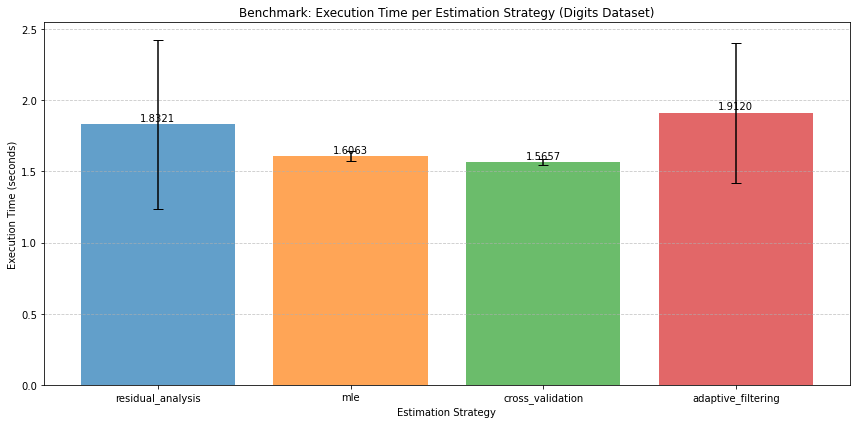

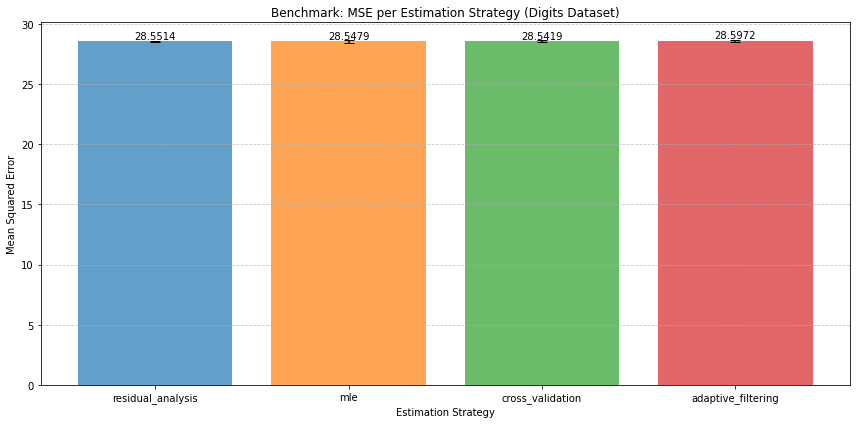

In [8]:
import time
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statistics import mean, stdev
# from your_module import DaskParticleFilter  # Adjust import

# Load and prepare data
digits = load_digits()
x = digits.data[0:20]  
y = digits.target[0:20]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(20, 64))  # 160 samples
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)

# Particle Filter parameters
n_features = 64
F = np.eye(n_features) * 0.99  # Slight drift
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
initial_state = x_train[0]

# Strategies to benchmark
strategies = ["residual_analysis", "mle", "cross_validation", "adaptive_filtering"]

# Benchmark settings
n_runs = 5  # Number of runs for statistical robustness
results = {strategy: {'times': [], 'mse': []} for strategy in strategies}

# Benchmark execution
for strategy in strategies:
    print(f"\nBenchmarking strategy: {strategy}")
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        pf = DaskParticleFilter(
            state_transition=F,
            observation_model=H,
            process_noise_cov=Q,
            observation_noise_cov=R,
            initial_state=initial_state,
            num_particles=1000,
            use_dask=True,
            estimation_strategy=strategy
        )
        
        start_time = time.time()
        state_estimates, _ = pf.run_filter(noisy_x_train_dask)
        denoised_x_train = state_estimates.compute()
        end_time = time.time()
        
        execution_time = end_time - start_time
        mse = np.mean((x_train - denoised_x_train) ** 2)
        
        results[strategy]['times'].append(execution_time)
        results[strategy]['mse'].append(mse)
        print(f"  Time: {execution_time:.4f}s, MSE: {mse:.4f}")

# Compute statistics
stats = {}
for strategy in strategies:
    times = results[strategy]['times']
    mse_vals = results[strategy]['mse']
    stats[strategy] = {
        'mean_time': mean(times),
        'std_time': stdev(times) if len(times) > 1 else 0,
        'mean_mse': mean(mse_vals),
        'std_mse': stdev(mse_vals) if len(mse_vals) > 1 else 0
    }

# Report results
print("\nBenchmark Results:")
for strategy in strategies:
    s = stats[strategy]
    print(f"{strategy}:")
    print(f"  Mean Time: {s['mean_time']:.4f}s (±{s['std_time']:.4f})")
    print(f"  Mean MSE: {s['mean_mse']:.4f} (±{s['std_mse']:.4f})")

# Visualization: Bar plot with error bars
strategies = list(stats.keys())
mean_times = [stats[s]['mean_time'] for s in strategies]
std_times = [stats[s]['std_time'] for s in strategies]
mean_mse = [stats[s]['mean_mse'] for s in strategies]
std_mse = [stats[s]['std_mse'] for s in strategies]

plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_times, yerr=std_times, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark: Execution Time per Estimation Strategy (Digits Dataset)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_mse, yerr=std_mse, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Mean Squared Error')
plt.title('Benchmark: MSE per Estimation Strategy (Digits Dataset)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_mse):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import dask.array as da
# from TFilterPy.base_estimator import BaseEstimator

import numpy as np
import dask.array as da

class BaseEstimator:
    """
    Base class for all estimators in the TFilterPy package.
    Provides common functionality such as parameter handling and validation.
    """

    def __init__(self, name=None):
        """
        Initialize the BaseEstimator.

        Args:
            name (str): Optional name for the estimator.
        """
        self.name = name or self.__class__.__name__

    @staticmethod
    def to_dask_array(numpy_array, chunk_size=None):
        """
        Convert a NumPy array to a Dask array with specified chunking.
        If chunk_size is None, use Dask's automatic chunking.
        
        Parameters:
            numpy_array (np.ndarray): Input array.
            chunk_size (int or tuple, optional): Desired chunk size.
            
        Returns:
            da.Array: Dask array version of numpy_array.
        """
        if chunk_size is None:
            return da.from_array(numpy_array, chunks="auto")
        else:
            # If a single integer is provided, use it for all dimensions.
            if isinstance(chunk_size, int):
                chunks = tuple(chunk_size for _ in range(numpy_array.ndim))
            else:
                chunks = chunk_size
            return da.from_array(numpy_array, chunks=chunks)
    
    def get_params(self, deep=True):
        """
        Get parameters of the estimator.

        Args:
            deep (bool): If True, retrieves parameters of nested objects.

        Returns:
            dict: A dictionary of parameter names mapped to their values.
        """
        params = {}
        for key, value in self.__dict__.items():
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                params.update({f"{key}__{k}": v for k, v in deep_items})
            else:
                params[key] = value
        return params

    def set_params(self, **params):
        """
        Set parameters of the estimator.

        Args:
            **params: Arbitrary keyword arguments of parameters to set.

        Returns:
            self: Returns the instance itself.
        """
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f"Invalid parameter: {key}")
            setattr(self, key, value)
        return self

    def validate_matrices(self, matrices):
        """
        Validate that matrices have consistent shapes.

        Args:
            matrices (dict): A dictionary of matrix names and their values.

        Raises:
            ValueError: If the matrices are inconsistent.
        """
        for name, matrix in matrices.items():
            if not isinstance(matrix, (np.ndarray, da.Array)):
                raise ValueError(f"{name} must be a NumPy or Dask array.")

    def __repr__(self):
        """
        String representation of the estimator.

        Returns:
            str: A string representation of the estimator.
        """
        return f"{self.name}({self.get_params(deep=False)})"


import dask.array as da
import numpy as np

class ParameterEstimator(BaseEstimator):
    r"""
    A class for estimating Kalman Filter parameters, such as process noise covariance (Q)
    and observation noise covariance (R), using different estimation methods.

    Estimation strategies include:
    - Residual Analysis
    - Maximum Likelihood Estimation (MLE)
    - Cross-Validation
    - Adaptive Filtering

    References:
    - Welch, G., & Bishop, G. (1995). An Introduction to the Kalman Filter.
    - Haykin, S. (2001). Kalman Filtering and Neural Networks.
    """

    def __init__(self, estimation_strategy: str = "residual_analysis"):
        r"""
        Initialize the ParameterEstimator with the desired estimation strategy.

        Parameters
        ----------
        estimation_strategy : str, optional
            The strategy to use for estimating parameters. Options include:
            - "residual_analysis": Estimate based on residuals after running the filter.
            - "mle": Maximum Likelihood Estimation (iterative approach).
            - "cross_validation": Perform k-fold cross-validation for best Q and R.
            - "adaptive_filtering": Dynamically update Q and R based on measurement residuals.

        Raises
        ------
        ValueError
            If an invalid estimation strategy is specified.
        """
        super().__init__(name="KalmanFilterParameterEstimator")
        valid_strategies = {
            "residual_analysis",
            "mle",
            "cross_validation",
            "adaptive_filtering",
        }
        if estimation_strategy not in valid_strategies:
            raise ValueError(
                f"Invalid strategy: {estimation_strategy}. Must be one of {valid_strategies}."
            )
        self.estimation_strategy = estimation_strategy

    def estimate_with_residual_analysis(self, measurements: da.Array) -> tuple:
        r"""
        Estimate process (Q) and observation (R) noise covariances using residual analysis.
        """
        state_estimates, residuals = self.run_filter(measurements)
        Q = da.cov(residuals, rowvar=False)
        # Use auto chunking for the identity matrix
        R = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
        return Q, R

    def estimate_with_mle(self, measurements: da.Array, max_iterations: int = 5) -> tuple:
        r"""
        Estimate Q and R using Maximum Likelihood Estimation (MLE).
        """
        Q, R = self.Q, self.R

        for _ in range(max_iterations):
            state_estimates, residuals = self.run_filter(measurements)
            # Use "auto" chunking for the identity matrices
            Q_new = da.eye(residuals.shape[1], chunks="auto") * da.var(residuals, axis=0)
            R_new = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            # Persist intermediate results to avoid recomputation overhead
            Q, R = Q_new.persist(), R_new.persist()

        return Q, R

    def estimate_with_cross_validation(self, measurements: da.Array, k_folds: int = 5) -> tuple:
        r"""
        Estimate Q and R using k-fold cross-validation.
        """
        n_samples = measurements.shape[0]
        fold_size = n_samples // k_folds

        fold_scores, fold_Qs, fold_Rs = [], [], []

        for fold in range(k_folds):
            val_start = fold * fold_size
            val_end = val_start + fold_size
            train_data = da.concatenate([measurements[:val_start], measurements[val_end:]])
            val_data = measurements[val_start:val_end]

            state_estimates, residuals = self.run_filter(train_data)
            val_score = da.mean((val_data - state_estimates[:fold_size]) ** 2)
            fold_scores.append(val_score)

            Q_fold = da.cov(residuals.T)
            R_fold = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            fold_Qs.append(Q_fold)
            fold_Rs.append(R_fold)

        # Compute all folds lazily and choose the best fold
        fold_scores, fold_Qs, fold_Rs = da.compute(fold_scores, fold_Qs, fold_Rs)
        best_fold = np.argmin(fold_scores)
        return fold_Qs[best_fold], fold_Rs[best_fold]

    def estimate_with_adaptive_filtering(self, measurements: da.Array) -> tuple:
        r"""
        Estimate Q and R adaptively based on innovations over time.
        """
        Q, R = self.Q, self.R
        alpha = 0.01
        innovations = measurements - da.dot(self.H, self.x)
        outer_products = da.einsum("ij,ik->ijk", innovations, innovations)
        Q_new = da.mean(outer_products, axis=0).rechunk("auto")
        R_new = da.var(innovations, axis=0).rechunk("auto")

        Q = (1 - alpha) * Q + alpha * Q_new
        R = (1 - alpha) * R + alpha * R_new
        return Q, R

    def estimate_parameters(self, measurements: da.Array):
        r"""
        Estimate the parameters Q and R using the specified estimation strategy.
        """
        return getattr(self, f"estimate_with_{self.estimation_strategy}")(measurements)


import numpy as np
import dask.array as da
import dask

from typing import Union

# from TFilterPy.utils.optimisation_utils import ParameterEstimator


class DaskKalmanFilter(ParameterEstimator):
    r"""
    Dask-based implementation of a Kalman Filter that supports distributed computing for
    large datasets. This class extends the ParameterEstimator to estimate the process
    noise covariance (Q) and observation noise covariance (R) while applying Kalman Filtering
    on incoming measurements.

    The Kalman Filter is a recursive algorithm that estimates the state of a linear dynamic
    system from noisy measurements. This implementation leverages Dask to scale computations
    across distributed systems.

    Parameters
    ----------
    state_transition_matrix : np.ndarray or da.Array, shape (n_features, n_features)
        The state transition matrix (F) representing how the system evolves between states.

    observation_matrix : np.ndarray or da.Array, shape (n_observations, n_features)
        The observation matrix (H) that maps the true state space into the observed space.

    process_noise_cov : np.ndarray or da.Array, shape (n_features, n_features)
        Covariance matrix (Q) representing the process noise.

    observation_noise_cov : np.ndarray or da.Array, shape (n_observations, n_observations)
        Covariance matrix (R) representing the observation noise.

    initial_state : np.ndarray or da.Array, shape (n_features,)
        Initial state vector (x0) of the system.

    initial_covariance : np.ndarray or da.Array, shape (n_features, n_features)
        Initial state covariance matrix (P0), representing initial uncertainty in the state.

    estimation_strategy : str, optional, default="residual_analysis"
        The strategy for estimating Q and R. Can be one of:
        - "residual_analysis"
        - "mle"
        - "cross_validation"
        - "adaptive_filtering"

    Raises
    ------
    ValueError
        If matrix dimensions do not conform to Kalman Filter requirements.

    References
    ----------
    Welch, G., & Bishop, G. (1995). An Introduction to the Kalman Filter.
    """

    def __init__(
        self,
        state_transition_matrix: Union[np.ndarray, da.Array],
        observation_matrix: Union[np.ndarray, da.Array],
        process_noise_cov: Union[np.ndarray, da.Array],
        observation_noise_cov: Union[np.ndarray, da.Array],
        initial_state: Union[np.ndarray, da.Array],
        initial_covariance: Union[np.ndarray, da.Array],
        chunk_size: int = 64,
        estimation_strategy: str = "residual_analysis",
    ):

        # Initialize the parent class (ParameterEstimator)
        super().__init__(estimation_strategy)

        # Input validation and conversion to Dask arrays
        if state_transition_matrix.shape[0] != state_transition_matrix.shape[1]:
            raise ValueError("State transition matrix (F) must be square.")
        if observation_matrix.shape[1] != state_transition_matrix.shape[0]:
            raise ValueError(
                "Observation matrix (H) dimensions must be compatible with F."
            )
        if process_noise_cov.shape != state_transition_matrix.shape:
            raise ValueError("Process noise covariance (Q) dimensions must match F.")
        if observation_noise_cov.shape[0] != observation_noise_cov.shape[1]:
            raise ValueError("Observation noise covariance (R) must be square.")
        if initial_state.shape[0] != state_transition_matrix.shape[0]:
            raise ValueError("Initial state (x0) dimensions must match F.")
        if initial_covariance.shape != state_transition_matrix.shape:
            raise ValueError("Initial covariance (P0) dimensions must match F.")

        # Convert to Dask arrays if necessary
        self.F = (
            self.to_dask_array(state_transition_matrix, chunk_size)
            if isinstance(state_transition_matrix, np.ndarray)
            else state_transition_matrix
        )
        self.H = (
            self.to_dask_array(observation_matrix, chunk_size)
            if isinstance(observation_matrix, np.ndarray)
            else observation_matrix
        )
        self.Q = (
            self.to_dask_array(process_noise_cov, chunk_size)
            if isinstance(process_noise_cov, np.ndarray)
            else process_noise_cov
        )
        self.R = (
            self.to_dask_array(observation_noise_cov, chunk_size)
            if isinstance(observation_noise_cov, np.ndarray)
            else observation_noise_cov
        )
        self.x = (
            self.to_dask_array(initial_state, chunk_size)
            if isinstance(initial_state, np.ndarray)
            else initial_state
        )
        self.P = (
            self.to_dask_array(initial_covariance, chunk_size)
            if isinstance(initial_covariance, np.ndarray)
            else initial_covariance
        )

    def fit(self, X: Union[np.ndarray, da.Array]) -> "DaskKalmanFilter":
        r"""
        Prepare the Kalman Filter by storing the measurements as a Dask array.

        Parameters
        ----------
        X : np.ndarray or da.Array, shape (n_timesteps, n_observations)
            Array of measurements over time.

        Returns
        -------
        self : DaskKalmanFilter
            The fitted Kalman Filter instance.

        Raises
        ------
        ValueError
            If the input measurements are not 2-dimensional.
        """
        if X.ndim != 2:
            raise ValueError(
                f"Measurements must be a 2D array. Received array with shape {X.shape}."
            )

        if isinstance(X, da.Array):
            self.X = X
        else:
            self.X = da.from_array(X, chunks=(X.shape[0] // 4, X.shape[1]))
        return self

    def predict(self) -> da.Array:
        r"""
        Perform state estimation over all time steps using the Kalman Filter algorithm.

        This method constructs a Dask computation graph to process the entire measurement
        sequence in parallel using delayed execution.

        Returns
        -------
        state_estimates : da.Array, shape (n_timesteps, n_features)
            The estimated state at each time step.

        Notes
        -----
        - The Kalman Filter operates in two steps: prediction and update.
        - Predictions are made using the state transition matrix F.
        - Updates are performed using the observation matrix H and Kalman Gain K.
        - This method leverages Dask to parallelize the filter process over multiple time steps.
        """

        @dask.delayed
        def kalman_step(i, x, P, F, H, Q, R, measurements):
            x = da.dot(F, x)
            P = da.dot(da.dot(F, P), F.T) + Q

            y = measurements[i] - da.dot(H, x)
            S = da.dot(da.dot(H, P), H.T) + R
            K = da.dot(da.dot(P, H.T), da.linalg.inv(S))
            x = x + da.dot(K, y)
            I = da.eye(P.shape[0], chunks=P.chunks[0][0])
            P = da.dot(I - da.dot(K, H), P)
            return (x, P)

        n_timesteps = self.X.shape[0]
        state_estimates = []
        x, P = self.x, self.P

        for i in range(n_timesteps):
            delayed_result = kalman_step(
                i, x, P, self.F, self.H, self.Q, self.R, self.X
            )
            x, P = dask.compute(delayed_result)[0]
            state_estimates.append(x)

        state_estimates = da.stack(state_estimates, axis=0)
        return state_estimates

    def run_filter(self, measurements: da.Array) -> tuple:
        r"""
        Apply the Kalman Filter on measurements to compute state estimates and residuals.

        Parameters
        ----------
        measurements : da.Array, shape (n_timesteps, n_observations)
            Observed measurements over time.

        Returns
        -------
        state_estimates : da.Array, shape (n_timesteps, n_features)
            Estimated states over the measurement timeline.
        residuals : da.Array, shape (n_timesteps, n_observations)
            Difference between observed and predicted measurements (innovations).

        Notes
        -----
        - This function is used by parameter estimation strategies to compute residuals.
        - Residuals are used for adaptive filtering and cross-validation strategies.
        """
        n_timesteps = measurements.shape[0]
        state_estimates = []
        residuals = []

        x, P = self.x, self.P

        for i in range(n_timesteps):
            x = da.dot(self.F, x)
            P = da.dot(da.dot(self.F, P), self.F.T) + self.Q

            y = measurements[i] - da.dot(self.H, x)
            S = da.dot(da.dot(self.H, P), self.H.T) + self.R
            K = da.dot(da.dot(P, self.H.T), da.linalg.inv(S))
            x = x + da.dot(K, y)
            I = da.eye(P.shape[0], chunks=P.chunks[0][0])
            P = da.dot(I - da.dot(K, self.H), P)

            state_estimates.append(x)
            residuals.append(y)

        state_estimates = da.stack(state_estimates, axis=0)
        residuals = da.stack(residuals, axis=0)
        return state_estimates, residuals

    def estimate_parameters(self, measurements: da.Array) -> tuple:
        """
        Estimate process (Q) and observation (R) noise covariances using the specified strategy.

        Parameters
        ----------
        measurements : da.Array, shape (n_timesteps, n_observations)
            Observed measurements over time.

        Returns
        -------
        Q : da.Array, shape (n_features, n_features)
            Estimated process noise covariance matrix.
        R : da.Array, shape (n_features, n_features)
            Estimated observation noise covariance matrix.

        Notes
        -----
        - This method calls the appropriate estimation strategy from the parent class.
        - The available strategies include residual analysis, MLE, cross-validation,
          and adaptive filtering.
        """
        return super().estimate_parameters(measurements)


In [12]:
import time
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statistics import mean, stdev
# from your_module import DaskKalmanFilter  # Adjust import

# Load and prepare data
digits = load_digits()
x = digits.data[0:200]  # Use 200 samples for robust benchmarking
y = digits.target[0:200]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(20, 64))  # 160 samples
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)

# Kalman Filter parameters
n_features = 64
F = np.eye(n_features) * 0.99  # Slight drift
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)

# Strategies to benchmark
strategies = ["residual_analysis", "mle", "cross_validation", "adaptive_filtering"]

# Benchmark settings
n_runs = 2  # Number of runs for statistical robustness
results = {strategy: {'times': [], 'mse': []} for strategy in strategies}

# Benchmark execution
for strategy in strategies:
    print(f"\nBenchmarking strategy: {strategy}")
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        kf = DaskKalmanFilter(
            state_transition_matrix=F,
            observation_matrix=H,
            process_noise_cov=Q,
            observation_noise_cov=R,
            initial_state=x0,
            initial_covariance=P0,
            estimation_strategy=strategy
        )
        
        start_time = time.time()
        kf.fit(noisy_x_train_dask)  # Fit the filter
        denoised_x_train = kf.predict().compute()  # Predict denoised states
        end_time = time.time()
        
        execution_time = end_time - start_time
        mse = np.mean((x_train - denoised_x_train) ** 2)
        
        results[strategy]['times'].append(execution_time)
        results[strategy]['mse'].append(mse)
        print(f"  Time: {execution_time:.4f}s, MSE: {mse:.4f}")

# Compute statistics
stats = {}
for strategy in strategies:
    times = results[strategy]['times']
    mse_vals = results[strategy]['mse']
    stats[strategy] = {
        'mean_time': mean(times),
        'std_time': stdev(times) if len(times) > 1 else 0,
        'mean_mse': mean(mse_vals),
        'std_mse': stdev(mse_vals) if len(mse_vals) > 1 else 0
    }

# Report results
print("\nBenchmark Results:")
for strategy in strategies:
    s = stats[strategy]
    print(f"{strategy}:")
    print(f"  Mean Time: {s['mean_time']:.4f}s (±{s['std_time']:.4f})")
    print(f"  Mean MSE: {s['mean_mse']:.4f} (±{s['std_mse']:.4f})")

# Visualization: Bar plot with error bars for execution time
strategies = list(stats.keys())
mean_times = [stats[s]['mean_time'] for s in strategies]
std_times = [stats[s]['std_time'] for s in strategies]
mean_mse = [stats[s]['mean_mse'] for s in strategies]
std_mse = [stats[s]['std_mse'] for s in strategies]

plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_times, yerr=std_times, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark: Execution Time per Estimation Strategy (Digits Dataset, Kalman Filter)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Optional: MSE plot
plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_mse, yerr=std_mse, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Mean Squared Error')
plt.title('Benchmark: MSE per Estimation Strategy (Digits Dataset, Kalman Filter)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_mse):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


Benchmarking strategy: residual_analysis
Run 1/2
  Time: 25.1462s, MSE: 11.7746
Run 2/2


KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
import matplotlib.pyplot as plt

# Data setup
digits = load_digits()
x = digits.data[0:200]
x_train, _, _, _ = train_test_split(x, digits.target[0:200], test_size=0.2, random_state=42)
x_train_dask = da.from_array(x_train, chunks=(20, 64))
noisy_x_train_dask = x_train_dask + da.random.normal(0, 0.88, x_train_dask.shape, chunks=x_train_dask.chunks)

# Common parameters
n_features = 64
F = np.eye(n_features) * 0.99
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)
strategies = ["residual_analysis", "mle", "cross_validation", "adaptive_filtering"]
n_runs = 5

# Benchmark function
def benchmark_filter(filter_class, name, **kwargs):
    results = {s: {'times': [], 'mse': []} for s in strategies}
    for strategy in strategies:
        print(f"\n{name} - {strategy}")
        for run in range(n_runs):
            filt = filter_class(estimation_strategy=strategy, **kwargs)
            start = time.time()
            if name == "Kalman":
                filt.fit(noisy_x_train_dask)
                denoised = filt.predict().compute()
            else:  # Particle
                denoised, _ = filt.run_filter(noisy_x_train_dask)
                denoised = denoised.compute()
            end = time.time()
            results[strategy]['times'].append(end - start)
            results[strategy]['mse'].append(np.mean((x_train - denoised) ** 2))
    stats = {s: {'mean_time': mean(r['times']), 'std_time': stdev(r['times']),
                 'mean_mse': mean(r['mse']), 'std_mse': stdev(r['mse'])}
             for s, r in results.items()}
    return stats

# Run benchmarks
kf_stats = benchmark_filter(DaskKalmanFilter, "Kalman", state_transition_matrix=F, 
                            observation_matrix=H, process_noise_cov=Q, 
                            observation_noise_cov=R, initial_state=x0, initial_covariance=P0)
pf_stats = benchmark_filter(DaskParticleFilter, "Particle", state_transition=F, 
                            observation_model=H, process_noise_cov=Q, 
                            observation_noise_cov=R, initial_state=x0, num_particles=1000, use_dask=True)

# Plotting function
def plot_benchmark(stats, title, metric, ylabel):
    strategies = list(stats.keys())
    means = [stats[s][f'mean_{metric}'] for s in strategies]
    stds = [stats[s][f'std_{metric}'] for s in strategies]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(strategies, means, yerr=stds, capsize=5, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    plt.xlabel('Estimation Strategy')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar, mean_val in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
                 f"{mean_val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Plot results
plot_benchmark(kf_stats, "Kalman Filter: Execution Time", "time", "Execution Time (seconds)")
plot_benchmark(kf_stats, "Kalman Filter: MSE", "mse", "Mean Squared Error")
plot_benchmark(pf_stats, "Particle Filter: Execution Time", "time", "Execution Time (seconds)")
plot_benchmark(pf_stats, "Particle Filter: MSE", "mse", "Mean Squared Error")


Kalman - residual_analysis

Kalman - mle

Kalman - cross_validation
